In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotion-detection-pak-news/pak_channels _news_articles.csv


In [2]:
!pip install transformers

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


from wordcloud import WordCloud
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional,Dropout

import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from transformers import BertTokenizer, BertConfig,AdamW, BertForSequenceClassification,get_linear_schedule_with_warmup

# **Read CSV Data**

In [4]:
df = pd.read_csv('../input/emotion-detection-pak-news/pak_channels _news_articles.csv', encoding="latin-1")
df.head()

Date   Author                                         News_Title  \
0  1-Jan-22  92_news  People demanded factories, but govt establishe...   
1  1-Jan-22  92_news  Govt knows inflation has increased in country:...   
2  1-Jan-22  92_news  IHC chief justice declared Person of Year for ...   
3  1-Jan-22  92_news  PPP releases white paper on 'bad performance' ...   
4  1-Jan-22  92_news  Prices of items in use of common man not incre...   

                                         Description  
0  ISLAMABAD (92 News) Ã¢ÂÂ Jamaat-e-Islami ame...  
1  LAHORE (92 News) Ã¢ÂÂ Federal Minister for E...  
2  ISLAMABAD (92 News) Ã¢ÂÂ The Center for Gove...  
3  KARACHI (92 News) Ã¢ÂÂ The Pakistan People's...  
4  KARACHI (92 News) Ã¢ÂÂ Finance Ministry Spok...

In [5]:
df.isnull().sum()

Date             6
Author           0
News_Title       6
Description    127
dtype: int64

In [6]:
news_df = df.dropna()

In [7]:
news_df.isnull().sum()

Date           0
Author         0
News_Title     0
Description    0
dtype: int64

# **Emotion Detection Using Bert**

In [8]:
from transformers import pipeline

In [9]:
motion = pipeline('sentiment-analysis', model='arpanghoshal/EmoRoBERTa')

Downloading:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

2022-07-19 14:54:05.237912: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 14:54:05.239021: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 14:54:05.239765: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 14:54:05.240634: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [12]:
news_df['News_Title'][15:25].apply(motion)

15    [{'label': 'neutral', 'score': 0.8161677718162...
16    [{'label': 'neutral', 'score': 0.9961036443710...
17    [{'label': 'neutral', 'score': 0.9920331835746...
18    [{'label': 'neutral', 'score': 0.9972088932991...
19    [{'label': 'neutral', 'score': 0.7230385541915...
20    [{'label': 'neutral', 'score': 0.9746221303939...
21    [{'label': 'neutral', 'score': 0.9964776635169...
22    [{'label': 'neutral', 'score': 0.9643817543983...
23    [{'label': 'neutral', 'score': 0.9955660700798...
24    [{'label': 'excitement', 'score': 0.7423324584...
Name: News_Title, dtype: object

In [16]:
def get_emotion_label(text):
  return(motion(text)[0]['label'])

In [17]:
get_emotion_label("Karachi matric board demands imposition of Section 144 around examination centres")

'neutral'

In [18]:
news_df['News_Title'][50:60].apply(get_emotion_label)

50     neutral
51     neutral
52     sadness
53     neutral
54     neutral
55     neutral
56     neutral
57    approval
58     neutral
59     neutral
Name: News_Title, dtype: object

In [19]:
news_df['Emotion'] = news_df['News_Title'].apply(get_emotion_label)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [66]:
news_df

Date            Author  \
0                    1-Jan-22           92_news   
1                    1-Jan-22           92_news   
2                    1-Jan-22           92_news   
3                    1-Jan-22           92_news   
4                    1-Jan-22           92_news   
...                       ...               ...   
15801   Thursday May 12 2022           Web Desk   
15802   Thursday May 12 2022   SHShahid Hussain   
15803   Thursday May 12 2022           Web Desk   
15804   Thursday May 12 2022    Awais Yousafzai   
15805   Thursday May 12 2022           Web Desk   

                                              News_Title  \
0      People demanded factories, but govt establishe...   
1      Govt knows inflation has increased in country:...   
2      IHC chief justice declared Person of Year for ...   
3      PPP releases white paper on 'bad performance' ...   
4      Prices of items in use of common man not incre...   
...                                                  ...   
15801  Heatwave alert: Sindh declares emergency to de...   
15802  FIA decides not to pursue money laundering cas...   
15803  Bilawal Bhutto says PTI minister threatened hi...   
15804  IHC bars police from registering further FIRs ...   
15805  Security of Chinese tops agenda of Bilawal Bhu...   

                                             Description  Emotion  
0      ISLAMABAD (92 News) Ã¢ÂÂ Jamaat-e-Islami ame...  neutral  
1      LAHORE (92 News) Ã¢ÂÂ Federal Minister for E...  neutral  
2      ISLAMABAD (92 News) Ã¢ÂÂ The Center for Gove...  neutral  
3      KARACHI (92 News) Ã¢ÂÂ The Pakistan People's...  neutral  
4      KARACHI (92 News) Ã¢ÂÂ Finance Ministry Spok...  neutral  
...                                                  ...      ...  
15801  KARACHI: Following the Pakistan Meteorological...  neutral  
15802  LAHORE: The Federal Investigation Agency (FIA)...  neutral  
15803  ISLAMABAD: Foreign Minister Bilawal Bhutto-Zar...  neutral  
15804  ISLAMABAD: The Islamabad High Court (IHC) Thur...  neutral  
15805  Foreign Minister Bilawal Bhutto-Zardari on Wed...  neutral  

[15679 rows x 5 columns]

Text(0.5, 1.0, 'Emotion Distribution')

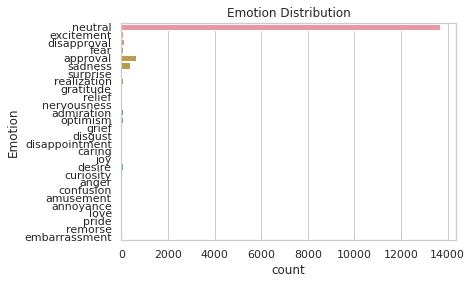

In [67]:
import seaborn as sns
sns.countplot(data = news_df, y = 'Emotion').set_title("Emotion Distribution")

In [129]:
news_df['Emotion'].unique()

array(['neutral', 'excitement', 'disapproval', 'fear', 'approval',
       'sadness', 'surprise', 'realization', 'gratitude', 'relief',
       'nervousness', 'admiration', 'optimism', 'grief', 'disgust',
       'disappointment', 'caring', 'joy', 'desire', 'curiosity', 'anger',
       'confusion', 'amusement', 'annoyance', 'love', 'pride', 'remorse',
       'embarrassment'], dtype=object)

# **Data Wise Analysis**

**Text Cleaning**

In [68]:
news_df["text_clean"] = news_df["News_Title"].apply(lambda x: x.lower())
display(news_df.head())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Date   Author                                         News_Title  \
0  1-Jan-22  92_news  People demanded factories, but govt establishe...   
1  1-Jan-22  92_news  Govt knows inflation has increased in country:...   
2  1-Jan-22  92_news  IHC chief justice declared Person of Year for ...   
3  1-Jan-22  92_news  PPP releases white paper on 'bad performance' ...   
4  1-Jan-22  92_news  Prices of items in use of common man not incre...   

                                         Description  Emotion  \
0  ISLAMABAD (92 News) Ã¢ÂÂ Jamaat-e-Islami ame...  neutral   
1  LAHORE (92 News) Ã¢ÂÂ Federal Minister for E...  neutral   
2  ISLAMABAD (92 News) Ã¢ÂÂ The Center for Gove...  neutral   
3  KARACHI (92 News) Ã¢ÂÂ The Pakistan People's...  neutral   
4  KARACHI (92 News) Ã¢ÂÂ Finance Ministry Spok...  neutral   

                                          text_clean  
0  people demanded factories, but govt establishe...  
1  govt knows inflation has increased in country:...  
2  ihc chief justice declared person of year for ...  
3  ppp releases white paper on 'bad performance' ...  
4  prices of items in use of common man not incre...

In [69]:
# Intall the contractions package - https://github.com/kootenpv/contractions
!pip install contractions

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 1.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 kB 3.3 MB/s eta 0:00:00a 0:00:01


In [70]:
# Tokenizing the  base texts.
from nltk.tokenize import word_tokenize

news_df['tokenized'] = news_df['text_clean'].apply(word_tokenize)
news_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Date   Author                                         News_Title  \
0  1-Jan-22  92_news  People demanded factories, but govt establishe...   
1  1-Jan-22  92_news  Govt knows inflation has increased in country:...   
2  1-Jan-22  92_news  IHC chief justice declared Person of Year for ...   
3  1-Jan-22  92_news  PPP releases white paper on 'bad performance' ...   
4  1-Jan-22  92_news  Prices of items in use of common man not incre...   

                                         Description  Emotion  \
0  ISLAMABAD (92 News) Ã¢ÂÂ Jamaat-e-Islami ame...  neutral   
1  LAHORE (92 News) Ã¢ÂÂ Federal Minister for E...  neutral   
2  ISLAMABAD (92 News) Ã¢ÂÂ The Center for Gove...  neutral   
3  KARACHI (92 News) Ã¢ÂÂ The Pakistan People's...  neutral   
4  KARACHI (92 News) Ã¢ÂÂ Finance Ministry Spok...  neutral   

                                          text_clean  \
0  people demanded factories, but govt establishe...   
1  govt knows inflation has increased in country:...   
2  ihc chief justice declared person of year for ...   
3  ppp releases white paper on 'bad performance' ...   
4  prices of items in use of common man not incre...   

                                           tokenized  
0  [people, demanded, factories, ,, but, govt, es...  
1  [govt, knows, inflation, has, increased, in, c...  
2  [ihc, chief, justice, declared, person, of, ye...  
3  [ppp, releases, white, paper, on, 'bad, perfor...  
4  [prices, of, items, in, use, of, common, man, ...

**Removing stopwords**

In [71]:
# Removing stopwords.
nltk.download("stopwords")
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))
news_df['stopwords_removed'] = news_df['tokenized'].apply(lambda x: [word for word in x if word not in stop])
news_df.head()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Date   Author                                         News_Title  \
0  1-Jan-22  92_news  People demanded factories, but govt establishe...   
1  1-Jan-22  92_news  Govt knows inflation has increased in country:...   
2  1-Jan-22  92_news  IHC chief justice declared Person of Year for ...   
3  1-Jan-22  92_news  PPP releases white paper on 'bad performance' ...   
4  1-Jan-22  92_news  Prices of items in use of common man not incre...   

                                         Description  Emotion  \
0  ISLAMABAD (92 News) Ã¢ÂÂ Jamaat-e-Islami ame...  neutral   
1  LAHORE (92 News) Ã¢ÂÂ Federal Minister for E...  neutral   
2  ISLAMABAD (92 News) Ã¢ÂÂ The Center for Gove...  neutral   
3  KARACHI (92 News) Ã¢ÂÂ The Pakistan People's...  neutral   
4  KARACHI (92 News) Ã¢ÂÂ Finance Ministry Spok...  neutral   

                                          text_clean  \
0  people demanded factories, but govt establishe...   
1  govt knows inflation has increased in country:...   
2  ihc chief justice declared person of year for ...   
3  ppp releases white paper on 'bad performance' ...   
4  prices of items in use of common man not incre...   

                                           tokenized  \
0  [people, demanded, factories, ,, but, govt, es...   
1  [govt, knows, inflation, has, increased, in, c...   
2  [ihc, chief, justice, declared, person, of, ye...   
3  [ppp, releases, white, paper, on, 'bad, perfor...   
4  [prices, of, items, in, use, of, common, man, ...   

                                   stopwords_removed  
0  [people, demanded, factories, ,, govt, establi...  
1  [govt, knows, inflation, increased, country, :...  
2  [ihc, chief, justice, declared, person, year, ...  
3  [ppp, releases, white, paper, 'bad, performanc...  
4  [prices, items, use, common, man, increased, m...

**Stemming**

In [72]:
from nltk.stem import PorterStemmer

def porter_stemmer(text):
    """
        Stem words in list of tokenized words with PorterStemmer
    """
    stemmer = nltk.PorterStemmer()
    stems = [stemmer.stem(i) for i in text]
    return stems

In [73]:
%time 

news_df['porter_stemmer'] = news_df['stopwords_removed'].apply(lambda x: porter_stemmer(x))
news_df.head()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 11.7 µs


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Date   Author                                         News_Title  \
0  1-Jan-22  92_news  People demanded factories, but govt establishe...   
1  1-Jan-22  92_news  Govt knows inflation has increased in country:...   
2  1-Jan-22  92_news  IHC chief justice declared Person of Year for ...   
3  1-Jan-22  92_news  PPP releases white paper on 'bad performance' ...   
4  1-Jan-22  92_news  Prices of items in use of common man not incre...   

                                         Description  Emotion  \
0  ISLAMABAD (92 News) Ã¢ÂÂ Jamaat-e-Islami ame...  neutral   
1  LAHORE (92 News) Ã¢ÂÂ Federal Minister for E...  neutral   
2  ISLAMABAD (92 News) Ã¢ÂÂ The Center for Gove...  neutral   
3  KARACHI (92 News) Ã¢ÂÂ The Pakistan People's...  neutral   
4  KARACHI (92 News) Ã¢ÂÂ Finance Ministry Spok...  neutral   

                                          text_clean  \
0  people demanded factories, but govt establishe...   
1  govt knows inflation has increased in country:...   
2  ihc chief justice declared person of year for ...   
3  ppp releases white paper on 'bad performance' ...   
4  prices of items in use of common man not incre...   

                                           tokenized  \
0  [people, demanded, factories, ,, but, govt, es...   
1  [govt, knows, inflation, has, increased, in, c...   
2  [ihc, chief, justice, declared, person, of, ye...   
3  [ppp, releases, white, paper, on, 'bad, perfor...   
4  [prices, of, items, in, use, of, common, man, ...   

                                   stopwords_removed  \
0  [people, demanded, factories, ,, govt, establi...   
1  [govt, knows, inflation, increased, country, :...   
2  [ihc, chief, justice, declared, person, year, ...   
3  [ppp, releases, white, paper, 'bad, performanc...   
4  [prices, items, use, common, man, increased, m...   

                                      porter_stemmer  
0  [peopl, demand, factori, ,, govt, establish, '...  
1  [govt, know, inflat, increas, countri, :, hamm...  
2  [ihc, chief, justic, declar, person, year, bol...  
3  [ppp, releas, white, paper, 'bad, perform, ', ...  
4  [price, item, use, common, man, increas, mini-...

In [79]:
from nltk.stem import LancasterStemmer

def lancaster_stemmer(text):
    """
        Stem words in list of tokenized words with LancasterStemmer
    """
    stemmer = nltk.LancasterStemmer()
    stems = [stemmer.stem(i) for i in text]
    return stems

In [80]:
%time 

news_df['lancaster_stemmer'] = news_df['stopwords_removed'].apply(lambda x: lancaster_stemmer(x))
news_df.head()

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 9.78 µs


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Date   Author                                         News_Title  \
0  1-Jan-22  92_news  People demanded factories, but govt establishe...   
1  1-Jan-22  92_news  Govt knows inflation has increased in country:...   
2  1-Jan-22  92_news  IHC chief justice declared Person of Year for ...   
3  1-Jan-22  92_news  PPP releases white paper on 'bad performance' ...   
4  1-Jan-22  92_news  Prices of items in use of common man not incre...   

                                         Description  Emotion  \
0  ISLAMABAD (92 News) Ã¢ÂÂ Jamaat-e-Islami ame...  neutral   
1  LAHORE (92 News) Ã¢ÂÂ Federal Minister for E...  neutral   
2  ISLAMABAD (92 News) Ã¢ÂÂ The Center for Gove...  neutral   
3  KARACHI (92 News) Ã¢ÂÂ The Pakistan People's...  neutral   
4  KARACHI (92 News) Ã¢ÂÂ Finance Ministry Spok...  neutral   

                                          text_clean  \
0  people demanded factories, but govt establishe...   
1  govt knows inflation has increased in country:...   
2  ihc chief justice declared person of year for ...   
3  ppp releases white paper on 'bad performance' ...   
4  prices of items in use of common man not incre...   

                                           tokenized  \
0  [people, demanded, factories, ,, but, govt, es...   
1  [govt, knows, inflation, has, increased, in, c...   
2  [ihc, chief, justice, declared, person, of, ye...   
3  [ppp, releases, white, paper, on, 'bad, perfor...   
4  [prices, of, items, in, use, of, common, man, ...   

                                   stopwords_removed  \
0  [people, demanded, factories, ,, govt, establi...   
1  [govt, knows, inflation, increased, country, :...   
2  [ihc, chief, justice, declared, person, year, ...   
3  [ppp, releases, white, paper, 'bad, performanc...   
4  [prices, items, use, common, man, increased, m...   

                                      porter_stemmer  \
0  [peopl, demand, factori, ,, govt, establish, '...   
1  [govt, know, inflat, increas, countri, :, hamm...   
2  [ihc, chief, justic, declar, person, year, bol...   
3  [ppp, releas, white, paper, 'bad, perform, ', ...   
4  [price, item, use, common, man, increas, mini-...   

                               lemmatize_word_wo_pos  \
0  [people, demanded, factory, ,, govt, establish...   
1  [govt, know, inflation, increased, country, :,...   
2  [ihc, chief, justice, declared, person, year, ...   
3  [ppp, release, white, paper, 'bad, performance...   
4  [price, item, use, common, man, increased, min...   

                                   lancaster_stemmer  
0  [peopl, demand, fact, ,, govt, est, 'langarkha...  
1  [govt, know, infl, increas, country, :, hammad...  
2  [ihc, chief, just, decl, person, year, bold, s...  
3  [ppp, releas, whit, pap, 'bad, perform, ', gov...  
4  [pric, item, us, common, man, increas, mini-bu...

**Part of Speech Tagging (POS Tagging)**


In [81]:
from nltk.corpus import wordnet
from nltk.corpus import brown

wordnet_map = {"N":wordnet.NOUN, 
               "V":wordnet.VERB, 
               "J":wordnet.ADJ, 
               "R":wordnet.ADV
              }
    
train_sents = brown.tagged_sents(categories='news')
t0 = nltk.DefaultTagger('NN')
t1 = nltk.UnigramTagger(train_sents, backoff=t0)
t2 = nltk.BigramTagger(train_sents, backoff=t1)

def pos_tag_wordnet(text, pos_tag_type="pos_tag"):
    """
        Create pos_tag with wordnet format
    """
    pos_tagged_text = t2.tag(text)
    
    # map the pos tagging output with wordnet output 
    pos_tagged_text = [(word, wordnet_map.get(pos_tag[0])) if pos_tag[0] in wordnet_map.keys() else (word, wordnet.NOUN) for (word, pos_tag) in pos_tagged_text ]
    return pos_tagged_text

In [82]:
pos_tag_wordnet(news_df['stopwords_removed'][2])

[('ihc', 'n'),
 ('chief', 'n'),
 ('justice', 'n'),
 ('declared', 'v'),
 ('person', 'n'),
 ('year', 'n'),
 ('bold', 'n'),
 ('stance', 'n'),
 ('missing', 'v'),
 ('persons', 'n')]

In [83]:
%time 

news_df['combined_postag_wnet'] = news_df['stopwords_removed'].apply(lambda x: pos_tag_wordnet(x))

news_df.head()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Date   Author                                         News_Title  \
0  1-Jan-22  92_news  People demanded factories, but govt establishe...   
1  1-Jan-22  92_news  Govt knows inflation has increased in country:...   
2  1-Jan-22  92_news  IHC chief justice declared Person of Year for ...   
3  1-Jan-22  92_news  PPP releases white paper on 'bad performance' ...   
4  1-Jan-22  92_news  Prices of items in use of common man not incre...   

                                         Description  Emotion  \
0  ISLAMABAD (92 News) Ã¢ÂÂ Jamaat-e-Islami ame...  neutral   
1  LAHORE (92 News) Ã¢ÂÂ Federal Minister for E...  neutral   
2  ISLAMABAD (92 News) Ã¢ÂÂ The Center for Gove...  neutral   
3  KARACHI (92 News) Ã¢ÂÂ The Pakistan People's...  neutral   
4  KARACHI (92 News) Ã¢ÂÂ Finance Ministry Spok...  neutral   

                                          text_clean  \
0  people demanded factories, but govt establishe...   
1  govt knows inflation has increased in country:...   
2  ihc chief justice declared person of year for ...   
3  ppp releases white paper on 'bad performance' ...   
4  prices of items in use of common man not incre...   

                                           tokenized  \
0  [people, demanded, factories, ,, but, govt, es...   
1  [govt, knows, inflation, has, increased, in, c...   
2  [ihc, chief, justice, declared, person, of, ye...   
3  [ppp, releases, white, paper, on, 'bad, perfor...   
4  [prices, of, items, in, use, of, common, man, ...   

                                   stopwords_removed  \
0  [people, demanded, factories, ,, govt, establi...   
1  [govt, knows, inflation, increased, country, :...   
2  [ihc, chief, justice, declared, person, year, ...   
3  [ppp, releases, white, paper, 'bad, performanc...   
4  [prices, items, use, common, man, increased, m...   

                                      porter_stemmer  \
0  [peopl, demand, factori, ,, govt, establish, '...   
1  [govt, know, inflat, increas, countri, :, hamm...   
2  [ihc, chief, justic, declar, person, year, bol...   
3  [ppp, releas, white, paper, 'bad, perform, ', ...   
4  [price, item, use, common, man, increas, mini-...   

                               lemmatize_word_wo_pos  \
0  [people, demanded, factory, ,, govt, establish...   
1  [govt, know, inflation, increased, country, :,...   
2  [ihc, chief, justice, declared, person, year, ...   
3  [ppp, release, white, paper, 'bad, performance...   
4  [price, item, use, common, man, increased, min...   

                                   lancaster_stemmer  \
0  [peopl, demand, fact, ,, govt, est, 'langarkha...   
1  [govt, know, infl, increas, country, :, hammad...   
2  [ihc, chief, just, decl, person, year, bold, s...   
3  [ppp, releas, whit, pap, 'bad, perform, ', gov...   
4  [pric, item, us, common, man, increas, mini-bu...   

                                combined_postag_wnet  
0  [(people, n), (demanded, v), (factories, n), (...  
1  [(govt, n), (knows, v), (inflation, n), (incre...  
2  [(ihc, n), (chief, n), (justice, n), (declared...  
3  [(ppp, n), (releases, n), (white, a), (paper, ...  
4  [(prices, n), (items, n), (use, v), (common, a...

**Lemmatization**

In [74]:
from nltk.stem import WordNetLemmatizer

def lemmatize_word(text):
    """
        Lemmatize the tokenized words
    """

    lemmatizer = WordNetLemmatizer()
    lemma = [lemmatizer.lemmatize(word, tag) for word, tag in text]
    return lemma

In [75]:
#lemmatization without pos tagging
%time 

# Test without POS Tagging
lemmatizer = WordNetLemmatizer()

news_df['lemmatize_word_wo_pos'] = news_df['stopwords_removed'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
news_df['lemmatize_word_wo_pos'] = news_df['lemmatize_word_wo_pos'].apply(lambda x: [word for word in x if word not in stop])
news_df.head()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Date   Author                                         News_Title  \
0  1-Jan-22  92_news  People demanded factories, but govt establishe...   
1  1-Jan-22  92_news  Govt knows inflation has increased in country:...   
2  1-Jan-22  92_news  IHC chief justice declared Person of Year for ...   
3  1-Jan-22  92_news  PPP releases white paper on 'bad performance' ...   
4  1-Jan-22  92_news  Prices of items in use of common man not incre...   

                                         Description  Emotion  \
0  ISLAMABAD (92 News) Ã¢ÂÂ Jamaat-e-Islami ame...  neutral   
1  LAHORE (92 News) Ã¢ÂÂ Federal Minister for E...  neutral   
2  ISLAMABAD (92 News) Ã¢ÂÂ The Center for Gove...  neutral   
3  KARACHI (92 News) Ã¢ÂÂ The Pakistan People's...  neutral   
4  KARACHI (92 News) Ã¢ÂÂ Finance Ministry Spok...  neutral   

                                          text_clean  \
0  people demanded factories, but govt establishe...   
1  govt knows inflation has increased in country:...   
2  ihc chief justice declared person of year for ...   
3  ppp releases white paper on 'bad performance' ...   
4  prices of items in use of common man not incre...   

                                           tokenized  \
0  [people, demanded, factories, ,, but, govt, es...   
1  [govt, knows, inflation, has, increased, in, c...   
2  [ihc, chief, justice, declared, person, of, ye...   
3  [ppp, releases, white, paper, on, 'bad, perfor...   
4  [prices, of, items, in, use, of, common, man, ...   

                                   stopwords_removed  \
0  [people, demanded, factories, ,, govt, establi...   
1  [govt, knows, inflation, increased, country, :...   
2  [ihc, chief, justice, declared, person, year, ...   
3  [ppp, releases, white, paper, 'bad, performanc...   
4  [prices, items, use, common, man, increased, m...   

                                      porter_stemmer  \
0  [peopl, demand, factori, ,, govt, establish, '...   
1  [govt, know, inflat, increas, countri, :, hamm...   
2  [ihc, chief, justic, declar, person, year, bol...   
3  [ppp, releas, white, paper, 'bad, perform, ', ...   
4  [price, item, use, common, man, increas, mini-...   

                               lemmatize_word_wo_pos  
0  [people, demanded, factory, ,, govt, establish...  
1  [govt, know, inflation, increased, country, :,...  
2  [ihc, chief, justice, declared, person, year, ...  
3  [ppp, release, white, paper, 'bad, performance...  
4  [price, item, use, common, man, increased, min...

In [84]:
print(news_df["combined_postag_wnet"][10])
print(news_df["lemmatize_word_wo_pos"][10])

[('cctv', 'n'), ('footage', 'n'), ('bilal', 'n'), ('yasin', 'n'), ("'s", 'n'), ('attackers', 'n'), ('surfaces', 'n'), (',', 'n'), ('case', 'n'), ('registered', 'v')]
['cctv', 'footage', 'bilal', 'yasin', "'s", 'attacker', 'surface', ',', 'case', 'registered']


In [85]:
%time 

# Test with POS Tagging
lemmatizer = WordNetLemmatizer()

news_df['lemmatize_word_w_pos'] = news_df['combined_postag_wnet'].apply(lambda x: lemmatize_word(x))
news_df['lemmatize_word_w_pos'] = news_df['lemmatize_word_w_pos'].apply(lambda x: [word for word in x if word not in stop]) # double check to remove stop words
news_df['lemmatize_text'] = [' '.join(map(str, l)) for l in news_df['lemmatize_word_w_pos']] # join back to text

news_df.head()

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10 µs


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

Date   Author                                         News_Title  \
0  1-Jan-22  92_news  People demanded factories, but govt establishe...   
1  1-Jan-22  92_news  Govt knows inflation has increased in country:...   
2  1-Jan-22  92_news  IHC chief justice declared Person of Year for ...   
3  1-Jan-22  92_news  PPP releases white paper on 'bad performance' ...   
4  1-Jan-22  92_news  Prices of items in use of common man not incre...   

                                         Description  Emotion  \
0  ISLAMABAD (92 News) Ã¢ÂÂ Jamaat-e-Islami ame...  neutral   
1  LAHORE (92 News) Ã¢ÂÂ Federal Minister for E...  neutral   
2  ISLAMABAD (92 News) Ã¢ÂÂ The Center for Gove...  neutral   
3  KARACHI (92 News) Ã¢ÂÂ The Pakistan People's...  neutral   
4  KARACHI (92 News) Ã¢ÂÂ Finance Ministry Spok...  neutral   

                                          text_clean  \
0  people demanded factories, but govt establishe...   
1  govt knows inflation has increased in country:...   
2  ihc chief justice declared person of year for ...   
3  ppp releases white paper on 'bad performance' ...   
4  prices of items in use of common man not incre...   

                                           tokenized  \
0  [people, demanded, factories, ,, but, govt, es...   
1  [govt, knows, inflation, has, increased, in, c...   
2  [ihc, chief, justice, declared, person, of, ye...   
3  [ppp, releases, white, paper, on, 'bad, perfor...   
4  [prices, of, items, in, use, of, common, man, ...   

                                   stopwords_removed  \
0  [people, demanded, factories, ,, govt, establi...   
1  [govt, knows, inflation, increased, country, :...   
2  [ihc, chief, justice, declared, person, year, ...   
3  [ppp, releases, white, paper, 'bad, performanc...   
4  [prices, items, use, common, man, increased, m...   

                                      porter_stemmer  \
0  [peopl, demand, factori, ,, govt, establish, '...   
1  [govt, know, inflat, increas, countri, :, hamm...   
2  [ihc, chief, justic, declar, person, year, bol...   
3  [ppp, releas, white, paper, 'bad, perform, ', ...   
4  [price, item, use, common, man, increas, mini-...   

                               lemmatize_word_wo_pos  \
0  [people, demanded, factory, ,, govt, establish...   
1  [govt, know, inflation, increased, country, :,...   
2  [ihc, chief, justice, declared, person, year, ...   
3  [ppp, release, white, paper, 'bad, performance...   
4  [price, item, use, common, man, increased, min...   

                                   lancaster_stemmer  \
0  [peopl, demand, fact, ,, govt, est, 'langarkha...   
1  [govt, know, infl, increas, country, :, hammad...   
2  [ihc, chief, just, decl, person, year, bold, s...   
3  [ppp, releas, whit, pap, 'bad, perform, ', gov...   
4  [pric, item, us, common, man, increas, mini-bu...   

                                combined_postag_wnet  \
0  [(people, n), (demanded, v), (factories, n), (...   
1  [(govt, n), (knows, v), (inflation, n), (incre...   
2  [(ihc, n), (chief, n), (justice, n), (declared...   
3  [(ppp, n), (releases, n), (white, a), (paper, ...   
4  [(prices, n), (items, n), (use, v), (common, a...   

                                lemmatize_word_w_pos  \
0  [people, demand, factory, ,, govt, establish, ...   
1  [govt, know, inflation, increase, country, :, ...   
2  [ihc, chief, justice, declare, person, year, b...   
3  [ppp, release, white, paper, 'bad, performance...   
4  [price, item, use, common, man, increase, mini...   

                                      lemmatize_text  
0  people demand factory , govt establish 'langar...  
1  govt know inflation increase country : hammad ...  
2  ihc chief justice declare person year bold sta...  
3  ppp release white paper 'bad performance ' gov...  
4  price item use common man increase mini-budget...

In [86]:
print(news_df["News_Title"][8])
print(news_df["combined_postag_wnet"][8])
print(news_df["lemmatize_word_wo_pos"][8])
print(news_df["lemmatize_word_w_pos"][8])

Omicron spread: Micro-smart lockdown enforced in Karachi's Gulshan Iqbal area till Jan 14
[('omicron', 'n'), ('spread', 'v'), (':', 'n'), ('micro-smart', 'n'), ('lockdown', 'n'), ('enforced', 'v'), ('karachi', 'n'), ("'s", 'n'), ('gulshan', 'n'), ('iqbal', 'n'), ('area', 'n'), ('till', 'n'), ('jan', 'n'), ('14', 'n')]
['omicron', 'spread', ':', 'micro-smart', 'lockdown', 'enforced', 'karachi', "'s", 'gulshan', 'iqbal', 'area', 'till', 'jan', '14']
['omicron', 'spread', ':', 'micro-smart', 'lockdown', 'enforce', 'karachi', "'s", 'gulshan', 'iqbal', 'area', 'till', 'jan', '14']


In [87]:
display(news_df["News_Title"][0], news_df["lemmatize_text"][0])
display(news_df["News_Title"][5], news_df["lemmatize_text"][5])
display(news_df["News_Title"][10], news_df["lemmatize_text"][10])
display(news_df["News_Title"][15], news_df["lemmatize_text"][15])
display(news_df["News_Title"][20], news_df["lemmatize_text"][20])

"People demanded factories, but govt established 'langarkhanas': Sirajul Haq"

"people demand factory , govt establish 'langarkhanas ' : sirajul haq"

"Farewell to 'our national conscience' at funeral of South Africa's Tutu"

"farewell 'our national conscience ' funeral south africa 's tutu"

"CCTV footage of Bilal Yasin's attackers surfaces, case registered"

"cctv footage bilal yasin 's attacker surface , case register"

'Woman attempts suicide after butchering three daughters in Jhelum'

'woman attempt suicide butchering three daughter jhelum'

'British tennis player Emma Raducanu pulls out of Australian Open warm-up event'

'british tennis player emma raducanu pull australian open warm-up event'

In [89]:
news_df['Length'] = [len(x) for x in news_df['News_Title']]
news_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Date   Author                                         News_Title  \
0  1-Jan-22  92_news  People demanded factories, but govt establishe...   
1  1-Jan-22  92_news  Govt knows inflation has increased in country:...   
2  1-Jan-22  92_news  IHC chief justice declared Person of Year for ...   
3  1-Jan-22  92_news  PPP releases white paper on 'bad performance' ...   
4  1-Jan-22  92_news  Prices of items in use of common man not incre...   

                                         Description  Emotion  \
0  ISLAMABAD (92 News) Ã¢ÂÂ Jamaat-e-Islami ame...  neutral   
1  LAHORE (92 News) Ã¢ÂÂ Federal Minister for E...  neutral   
2  ISLAMABAD (92 News) Ã¢ÂÂ The Center for Gove...  neutral   
3  KARACHI (92 News) Ã¢ÂÂ The Pakistan People's...  neutral   
4  KARACHI (92 News) Ã¢ÂÂ Finance Ministry Spok...  neutral   

                                          text_clean  \
0  people demanded factories, but govt establishe...   
1  govt knows inflation has increased in country:...   
2  ihc chief justice declared person of year for ...   
3  ppp releases white paper on 'bad performance' ...   
4  prices of items in use of common man not incre...   

                                           tokenized  \
0  [people, demanded, factories, ,, but, govt, es...   
1  [govt, knows, inflation, has, increased, in, c...   
2  [ihc, chief, justice, declared, person, of, ye...   
3  [ppp, releases, white, paper, on, 'bad, perfor...   
4  [prices, of, items, in, use, of, common, man, ...   

                                   stopwords_removed  \
0  [people, demanded, factories, ,, govt, establi...   
1  [govt, knows, inflation, increased, country, :...   
2  [ihc, chief, justice, declared, person, year, ...   
3  [ppp, releases, white, paper, 'bad, performanc...   
4  [prices, items, use, common, man, increased, m...   

                                      porter_stemmer  \
0  [peopl, demand, factori, ,, govt, establish, '...   
1  [govt, know, inflat, increas, countri, :, hamm...   
2  [ihc, chief, justic, declar, person, year, bol...   
3  [ppp, releas, white, paper, 'bad, perform, ', ...   
4  [price, item, use, common, man, increas, mini-...   

                               lemmatize_word_wo_pos  \
0  [people, demanded, factory, ,, govt, establish...   
1  [govt, know, inflation, increased, country, :,...   
2  [ihc, chief, justice, declared, person, year, ...   
3  [ppp, release, white, paper, 'bad, performance...   
4  [price, item, use, common, man, increased, min...   

                                   lancaster_stemmer  \
0  [peopl, demand, fact, ,, govt, est, 'langarkha...   
1  [govt, know, infl, increas, country, :, hammad...   
2  [ihc, chief, just, decl, person, year, bold, s...   
3  [ppp, releas, whit, pap, 'bad, perform, ', gov...   
4  [pric, item, us, common, man, increas, mini-bu...   

                                combined_postag_wnet  \
0  [(people, n), (demanded, v), (factories, n), (...   
1  [(govt, n), (knows, v), (inflation, n), (incre...   
2  [(ihc, n), (chief, n), (justice, n), (declared...   
3  [(ppp, n), (releases, n), (white, a), (paper, ...   
4  [(prices, n), (items, n), (use, v), (common, a...   

                                lemmatize_word_w_pos  \
0  [people, demand, factory, ,, govt, establish, ...   
1  [govt, know, inflation, increase, country, :, ...   
2  [ihc, chief, justice, declare, person, year, b...   
3  [ppp, release, white, paper, 'bad, performance...   
4  [price, item, use, common, man, increase, mini...   

                                      lemmatize_text  Length  
0  people demand factory , govt establish 'langar...      75  
1  govt know inflation increase country : hammad ...      59  
2  ihc chief justice declare person year bold sta...      79  
3  ppp release white paper 'bad performance ' gov...      59  
4  price item use common man increase mini-budget...      96

# **Data Visualization**

In [112]:
def words_cloud(wordcloud, df):
    plt.figure(figsize=(10, 10))
    plt.title(df+' Word Cloud', size = 16)
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

In [113]:
emotions_list = news_df['Emotion'].unique()
emotions_list

array(['neutral', 'excitement', 'disapproval', 'fear', 'approval',
       'sadness', 'surprise', 'realization', 'gratitude', 'relief',
       'nervousness', 'admiration', 'optimism', 'grief', 'disgust',
       'disappointment', 'caring', 'joy', 'desire', 'curiosity', 'anger',
       'confusion', 'amusement', 'annoyance', 'love', 'pride', 'remorse',
       'embarrassment'], dtype=object)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


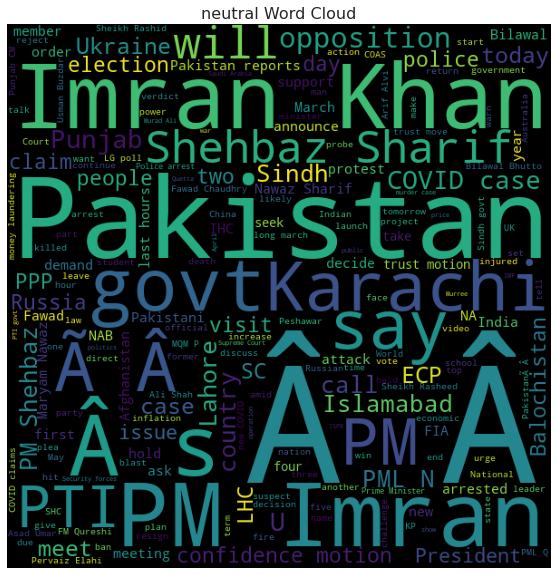

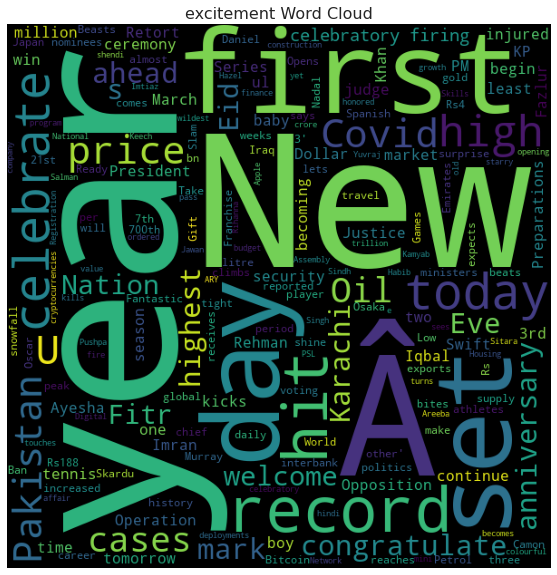

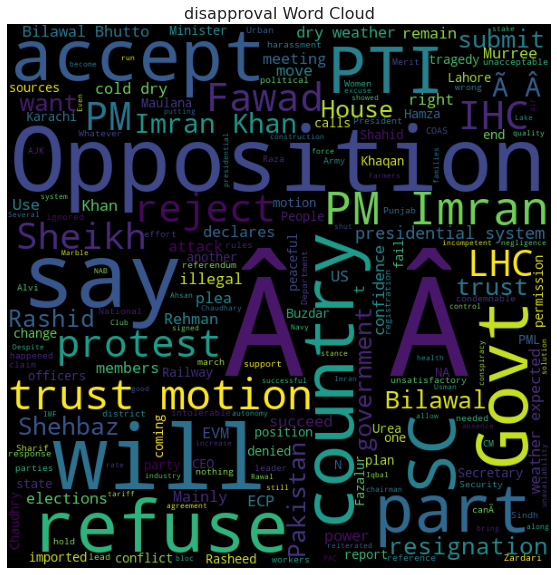

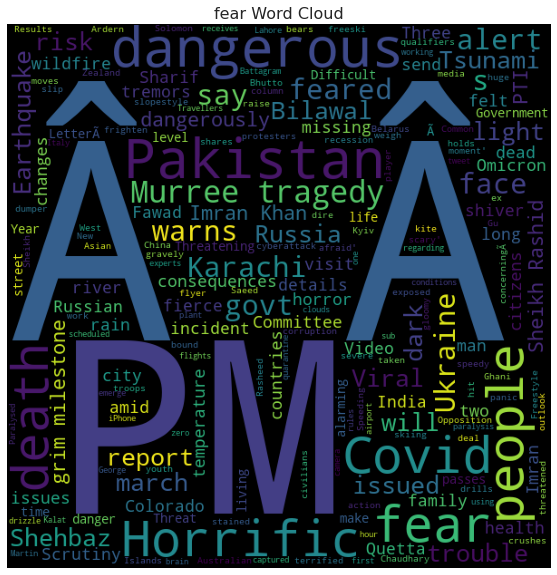

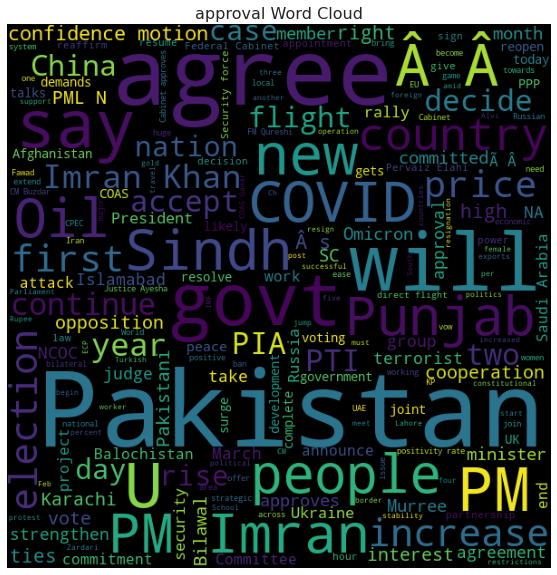

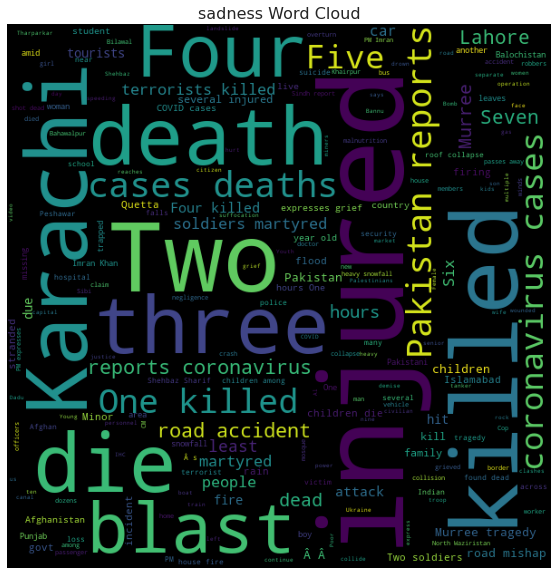

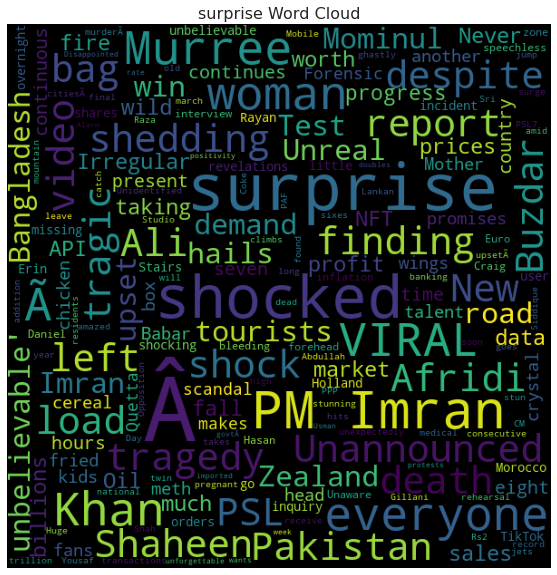

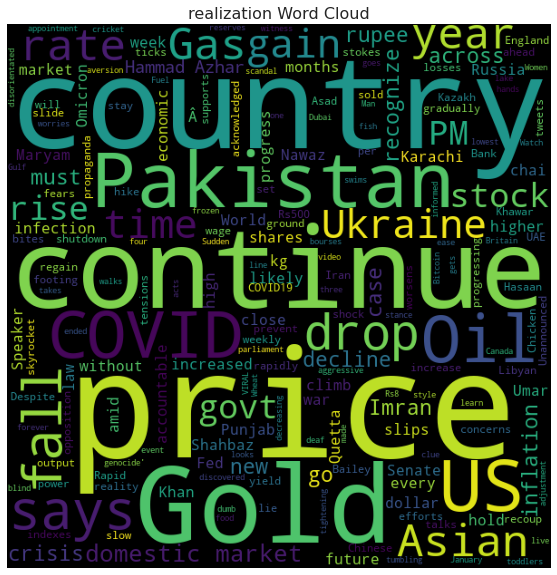

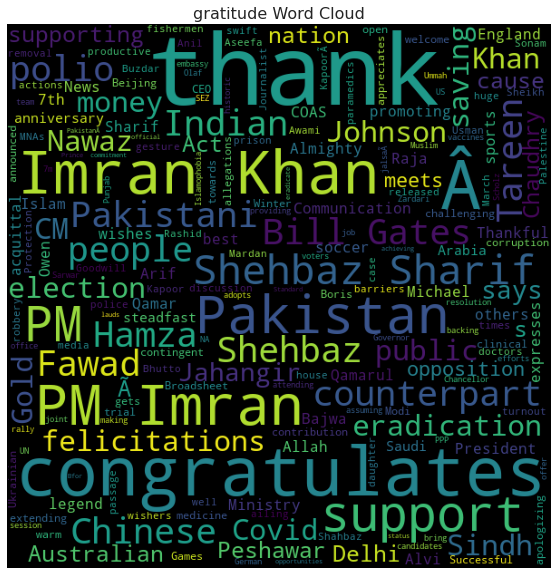

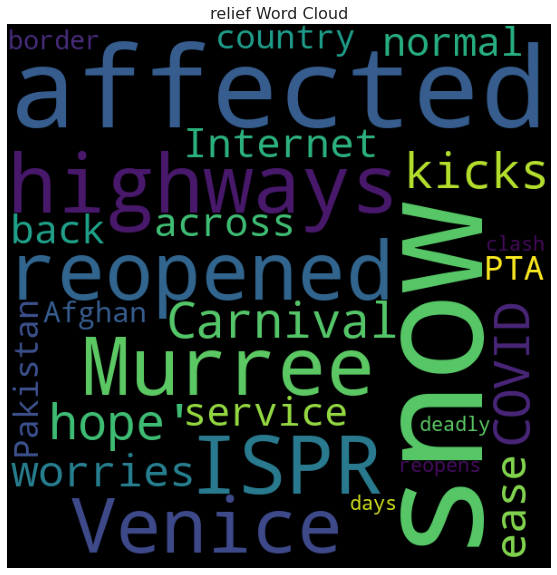

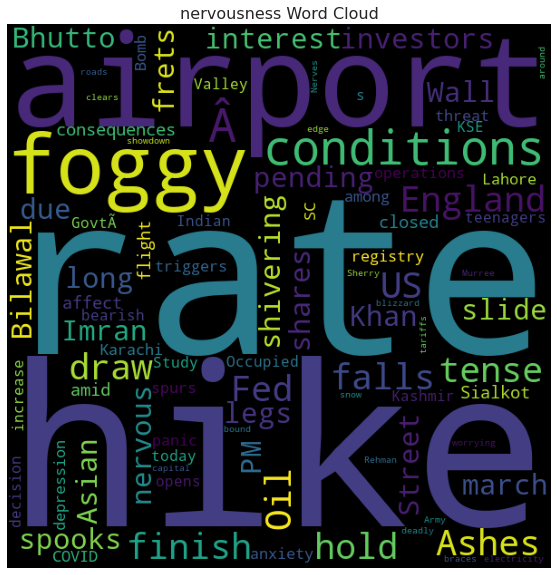

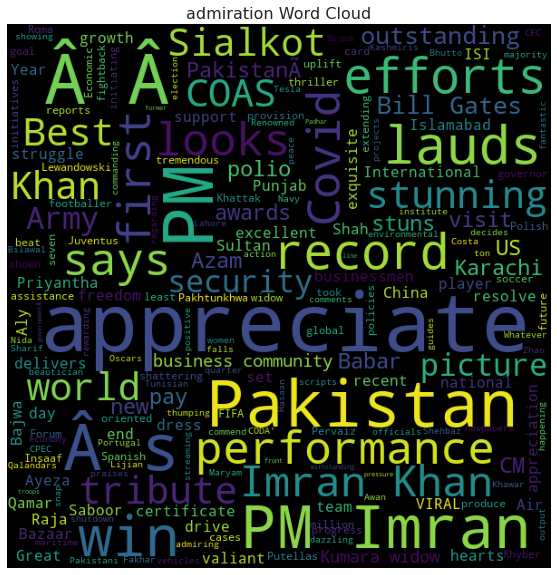

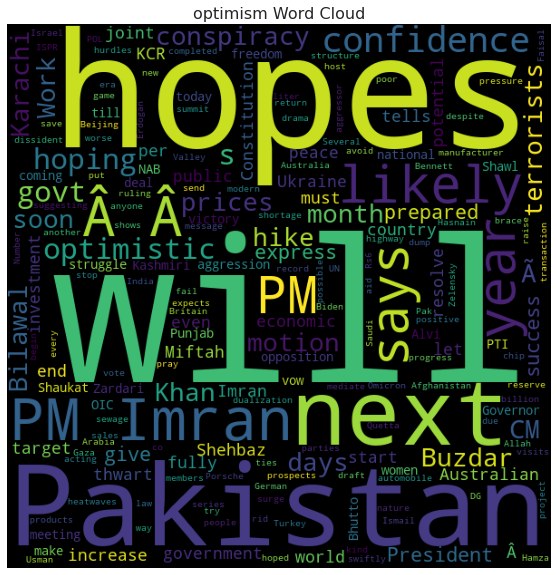

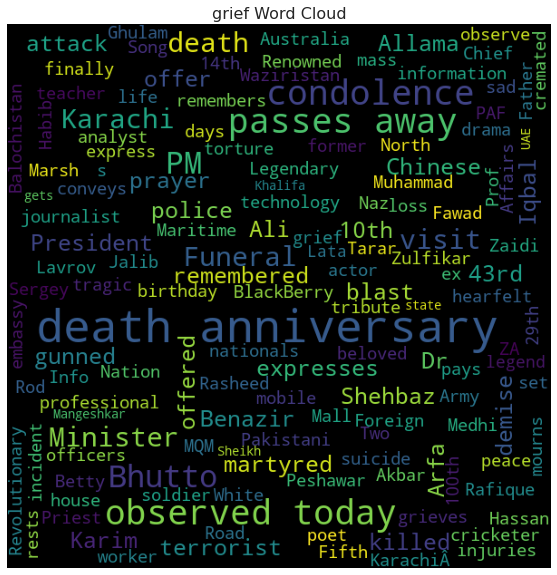

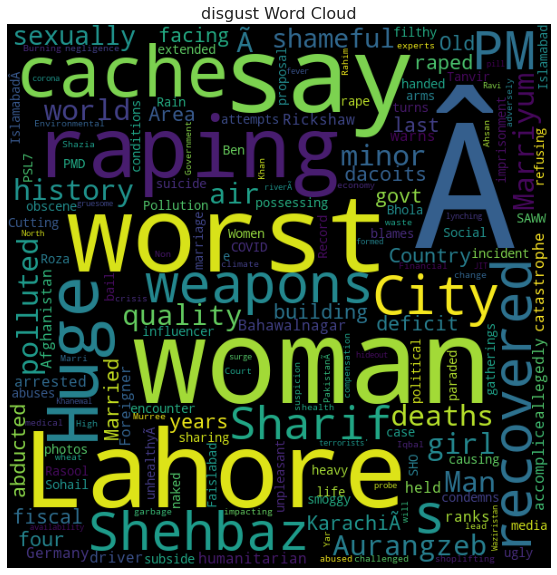

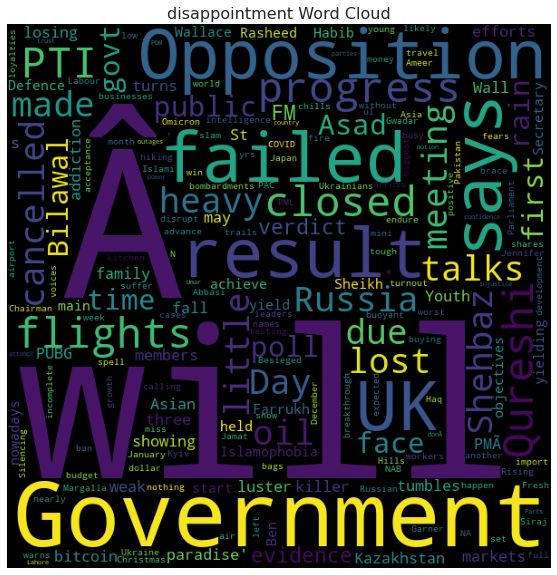

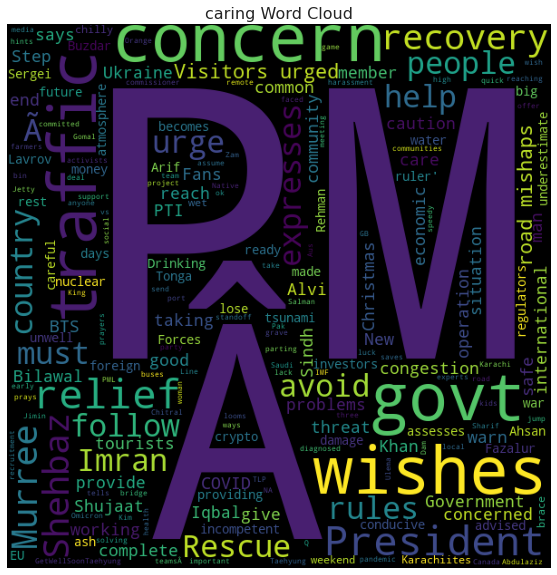

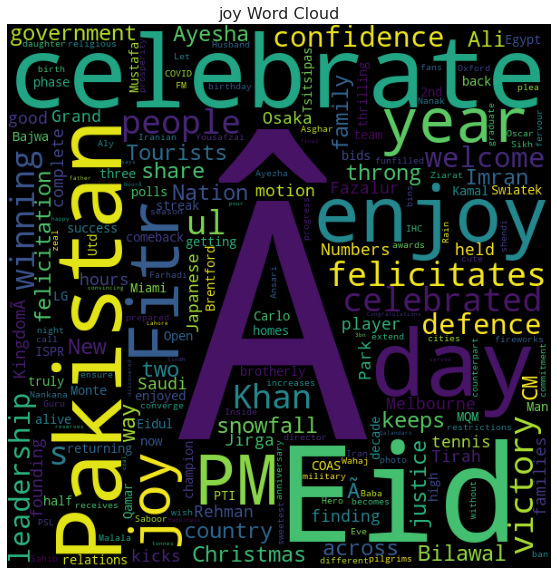

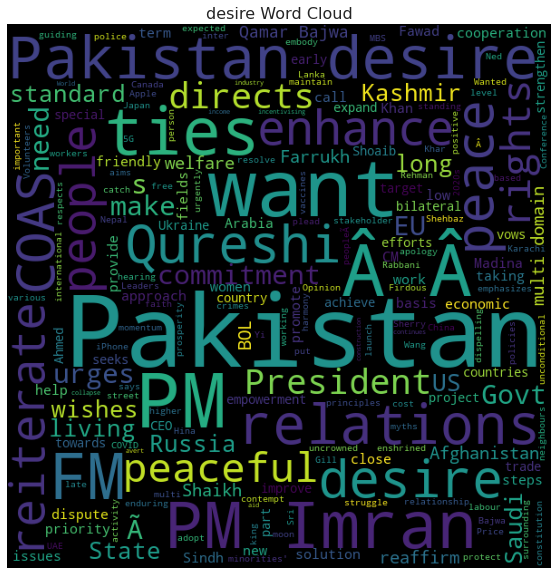

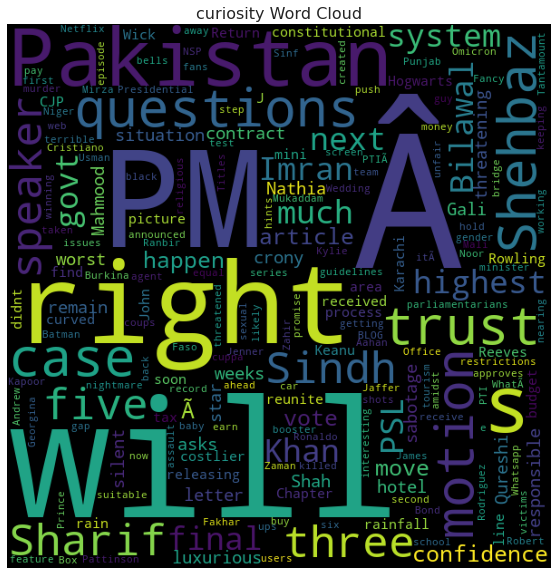

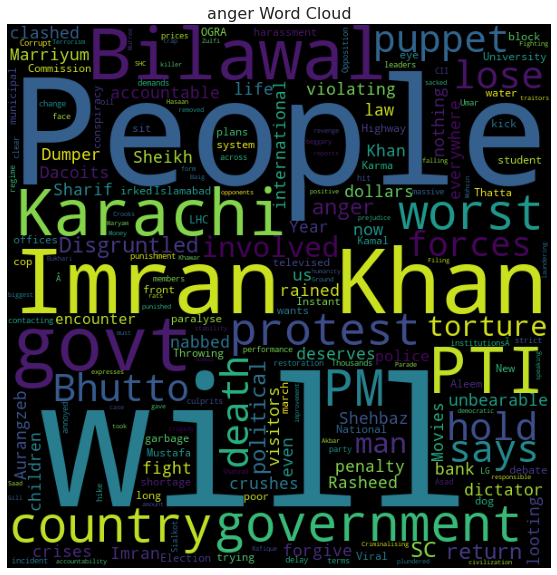

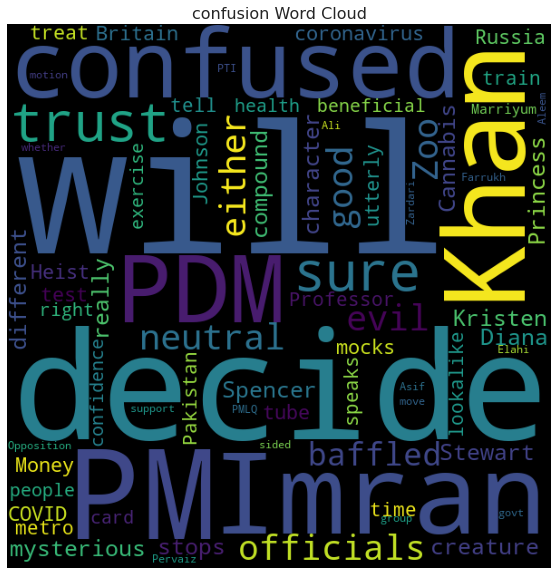

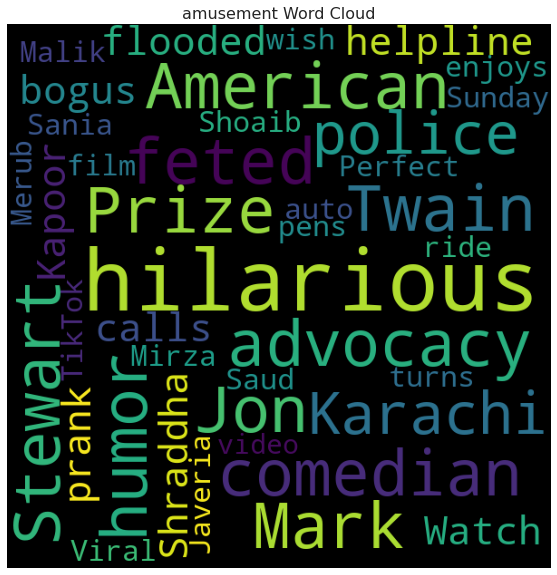

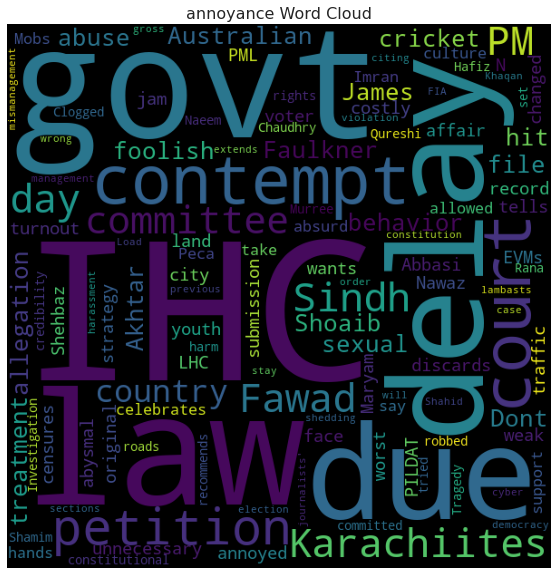

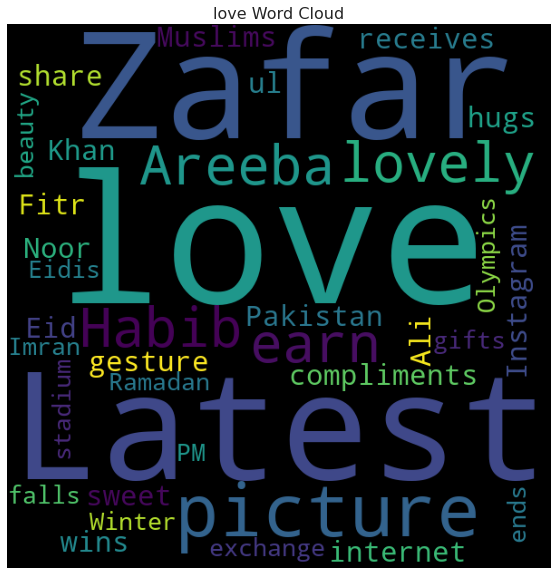

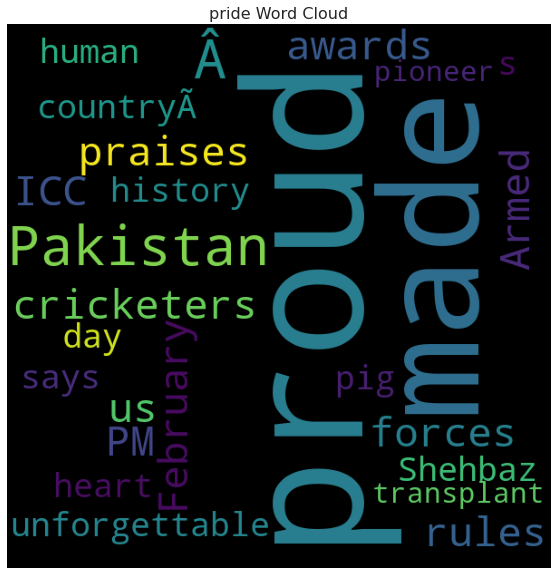

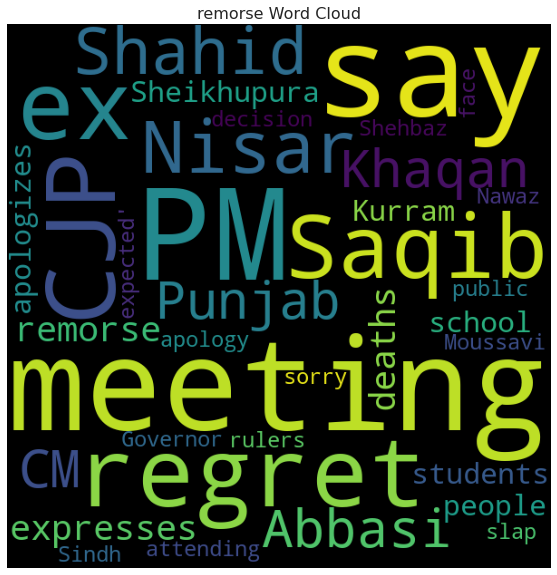

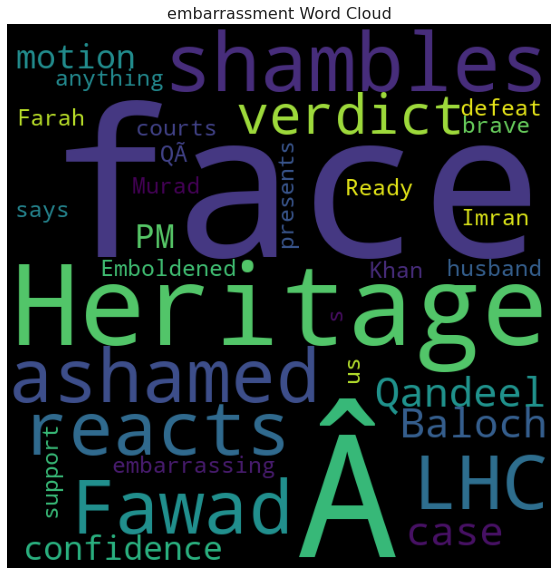

In [114]:
for emotion in emotions_list:
    text = ' '.join([sentence for sentence in news_df.loc[news_df['Emotion'] == emotion,'News_Title']])
    wordcloud = WordCloud(width = 600, height = 600).generate(text)
    words_cloud(wordcloud, emotion)

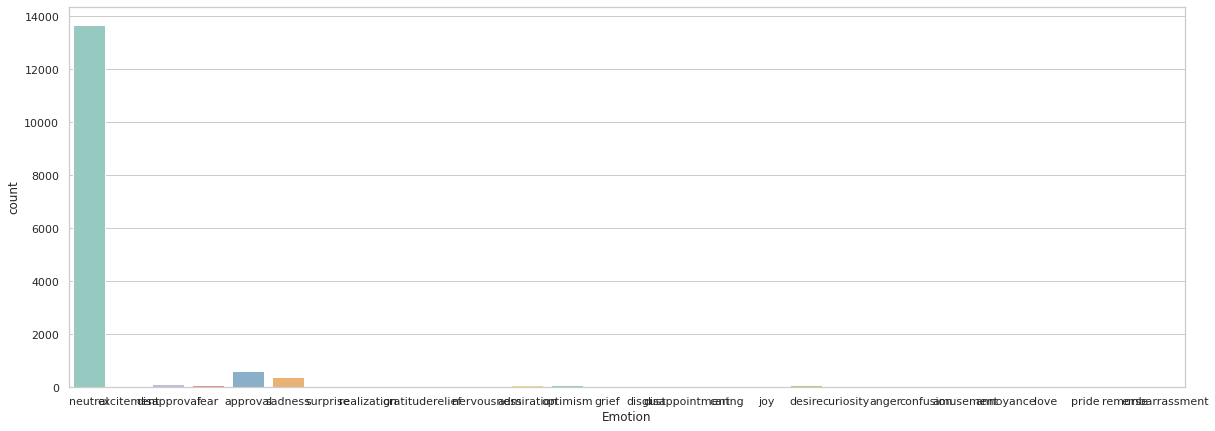

In [107]:
plt.figure(figsize = (20,7))
#sns.set_theme(style="darkgrid")

ax = sns.countplot(x="Emotion", data=news_df, palette="Set3", dodge=False)

In [119]:
from collections import Counter
news_df['temp_list'] = news_df['Emotion'].apply(lambda x:str(x).split())
top = Counter([item for sublist in news_df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
#temp.style.background_gradient(cmap='Blues')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [121]:
import plotly.express as px
fig = px.bar(temp, x="count", y="Common_words", title='Emotions Detection', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [128]:
# Tree of the most common words
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree Of Emotions')
fig.show()

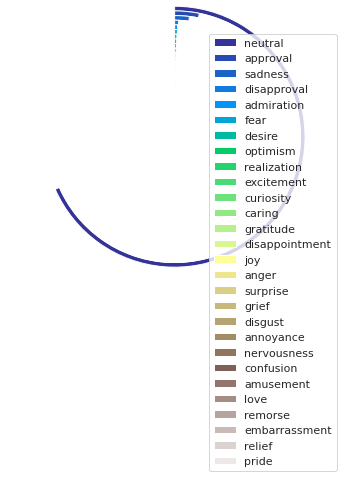

In [127]:
import matplotlib.pyplot as plt
from matplotlib import cm
from math import log10

labels = news_df.Emotion.value_counts().index.tolist()
data = news_df.Emotion.value_counts()
#number of data points
n = len(data)
#find max value for full ring
k = 10 ** int(log10(max(data)))
m = k * (1 + max(data) // k)

#radius of donut chart
r = 1.5
#calculate width of each ring
w = r / n 

#create colors along a chosen colormap
colors = [cm.terrain(i / n) for i in range(n)]

#create figure, axis
fig, ax = plt.subplots()
ax.axis("equal")

#create rings of donut chart
for i in range(n):
    #hide labels in segments with textprops: alpha = 0 - transparent, alpha = 1 - visible
    innerring, _ = ax.pie([m - data[i], data[i]], radius = r - i * w, startangle = 90, labels = ["", labels[i]], labeldistance = 1 - 1 / (1.5 * (n - i)), textprops = {"alpha": 0}, colors = ["white", colors[i]])
    plt.setp(innerring, width = w, edgecolor = "white")

plt.legend()
plt.show()

<AxesSubplot:ylabel='Density'>

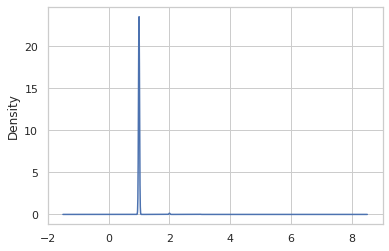

In [135]:
news_df.News_Title.value_counts().plot(kind='kde')

<AxesSubplot:>

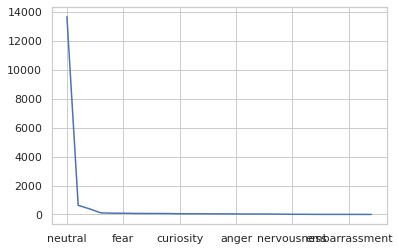

In [134]:
news_df.Emotion.value_counts().plot(kind='line')

In [151]:
# Plotly imports
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [156]:
news_df['Emotion'].unique()

array(['neutral', 'excitement', 'disapproval', 'fear', 'approval',
       'sadness', 'surprise', 'realization', 'gratitude', 'relief',
       'nervousness', 'admiration', 'optimism', 'grief', 'disgust',
       'disappointment', 'caring', 'joy', 'desire', 'curiosity', 'anger',
       'confusion', 'amusement', 'annoyance', 'love', 'pride', 'remorse',
       'embarrassment'], dtype=object)

In [177]:
hpl = news_df[news_df.Emotion=="sadness"]["Author"].values


(-0.5, 399.5, 199.5, -0.5)

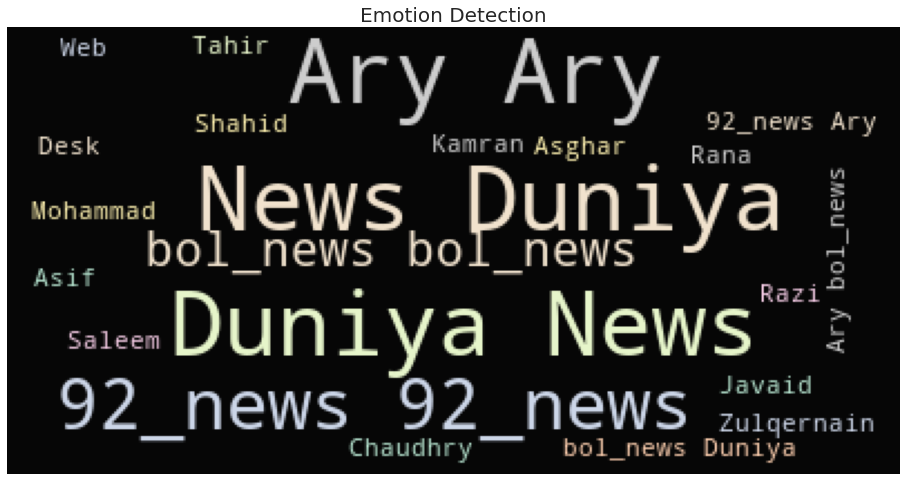

In [179]:
# The wordcloud of Cthulhu/squidy thing for HP Lovecraft
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=10000, stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(hpl))
plt.title("Emotion Detection", fontsize=20)
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

# **Model Bulding**

**Model1:**

In [24]:
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder


def get_label_encoder_obj(y):
    label_encoder = LabelEncoder()
    return label_encoder.fit(y)


def get_y_label_encoder(label_encoder, y):
    return label_encoder.transform(y)


def get_label_decoder(label_encoder, y):
    return label_encoder.classes_[y]


def one_hot_encode(y, num_classes):
    return to_categorical(y, num_classes=num_classes)

In [25]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(news_df, test_size=0.1, random_state=2, stratify=news_df["Emotion"])

In [26]:
label_encoder = get_label_encoder_obj(train["Emotion"])
train["Emotion"] = get_y_label_encoder(label_encoder, train["Emotion"])
val["Emotion"] = get_y_label_encoder(label_encoder, val["Emotion"])

In [27]:
num_classes = len(np.unique(train["Emotion"]))
num_classes

28

In [28]:
X_train = train["News_Title"].values
y_train = train["Emotion"].values
X_val = val["News_Title"].values
y_val = val["Emotion"].values

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

def CountVectorizer_fit(X_train, ngram_range=(1,1)):
    count_vect = CountVectorizer(ngram_range=ngram_range)
    return count_vect.fit(X_train)


def CountVectorizer_transform(count_vect, X):
    return count_vect.transform(X)

In [30]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
from itertools import cycle


def ROC_plot(y_true_ohe, y_hat_ohe, label_encoder, n_classes):    
    lw = 2
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_ohe[:, i], y_hat_ohe[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
                                  
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_ohe.ravel(), y_hat_ohe.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.figure(figsize=(20,20))
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(label_encoder.classes_[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("multiclass characteristic")
    plt.legend(loc="lower right")
    plt.show()

In [31]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix, classification_report, precision_score, recall_score
from sklearn.metrics import f1_score as f1_score_rep
import seaborn as sn


def print_score(y_pred, y_real, label_encoder):
    print("Accuracy: ", accuracy_score(y_real, y_pred))
    print("Precision:: ", precision_score(y_real, y_pred, average="micro"))
    print("Recall:: ", recall_score(y_real, y_pred, average="micro"))
    print("F1_Score:: ", f1_score_rep(y_real, y_pred, average="micro"))

    print()
    print("Macro precision_recall_fscore_support (macro) average")
    print(precision_recall_fscore_support(y_real, y_pred, average="macro"))

    print()
    print("Macro precision_recall_fscore_support (micro) average")
    print(precision_recall_fscore_support(y_real, y_pred, average="micro"))

    print()
    print("Macro precision_recall_fscore_support (weighted) average")
    print(precision_recall_fscore_support(y_real, y_pred, average="weighted"))
    
    print()
    print("Confusion Matrix")
    cm = confusion_matrix(y_real, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index = [i for i in label_encoder.classes_],
                  columns = [i for i in label_encoder.classes_])
    plt.figure(figsize = (20,20))
    sn.heatmap(df_cm, annot=True)

    print()
    print("Classification Report")
    print(classification_report(y_real, y_pred, target_names=label_encoder.classes_))

In [32]:
count_vect = CountVectorizer_fit(X_train, ngram_range=(1,3))
X_train_counts = CountVectorizer_transform(count_vect, X_train)
X_val_counts = CountVectorizer_transform(count_vect, X_val)

In [33]:
from sklearn.feature_extraction.text import TfidfTransformer


def TfidfTransformer_fit(X_train_counts, use_idf=True):
    tf_transformer = TfidfTransformer(use_idf=use_idf)
    return tf_transformer.fit(X_train_counts)


def TfidfTransformer_transform(tf_transformer, X_counts):
    return tf_transformer.transform(X_counts)

In [34]:
tf_transformer = TfidfTransformer_fit(X_train_counts)
X_train_tfidf = TfidfTransformer_transform(tf_transformer, X_train_counts)
X_val_tfidf = TfidfTransformer_transform(tf_transformer, X_val_counts)

In [35]:
from sklearn.model_selection import GridSearchCV

In [36]:
from sklearn.linear_model import SGDClassifier

%time
grid_params = { "loss": ["hinge", "log", "modified_huber"],
               "penalty": ["l1", "l2", "elasticnet"],
               "alpha": [1e-5],
               "max_iter":[15]
    
}

grid = GridSearchCV(SGDClassifier(), grid_params, refit=True, cv=3, verbose=1)
grid.fit(X_train_tfidf, y_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs
Fitting 3 folds for each of 9 candidates, totalling 27 fits


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_mo

GridSearchCV(cv=3, estimator=SGDClassifier(),
             param_grid={'alpha': [1e-05],
                         'loss': ['hinge', 'log', 'modified_huber'],
                         'max_iter': [15],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             verbose=1)

In [37]:
print(grid.best_params_)
print(grid.best_estimator_)

{'alpha': 1e-05, 'loss': 'hinge', 'max_iter': 15, 'penalty': 'l1'}
SGDClassifier(alpha=1e-05, max_iter=15, penalty='l1')


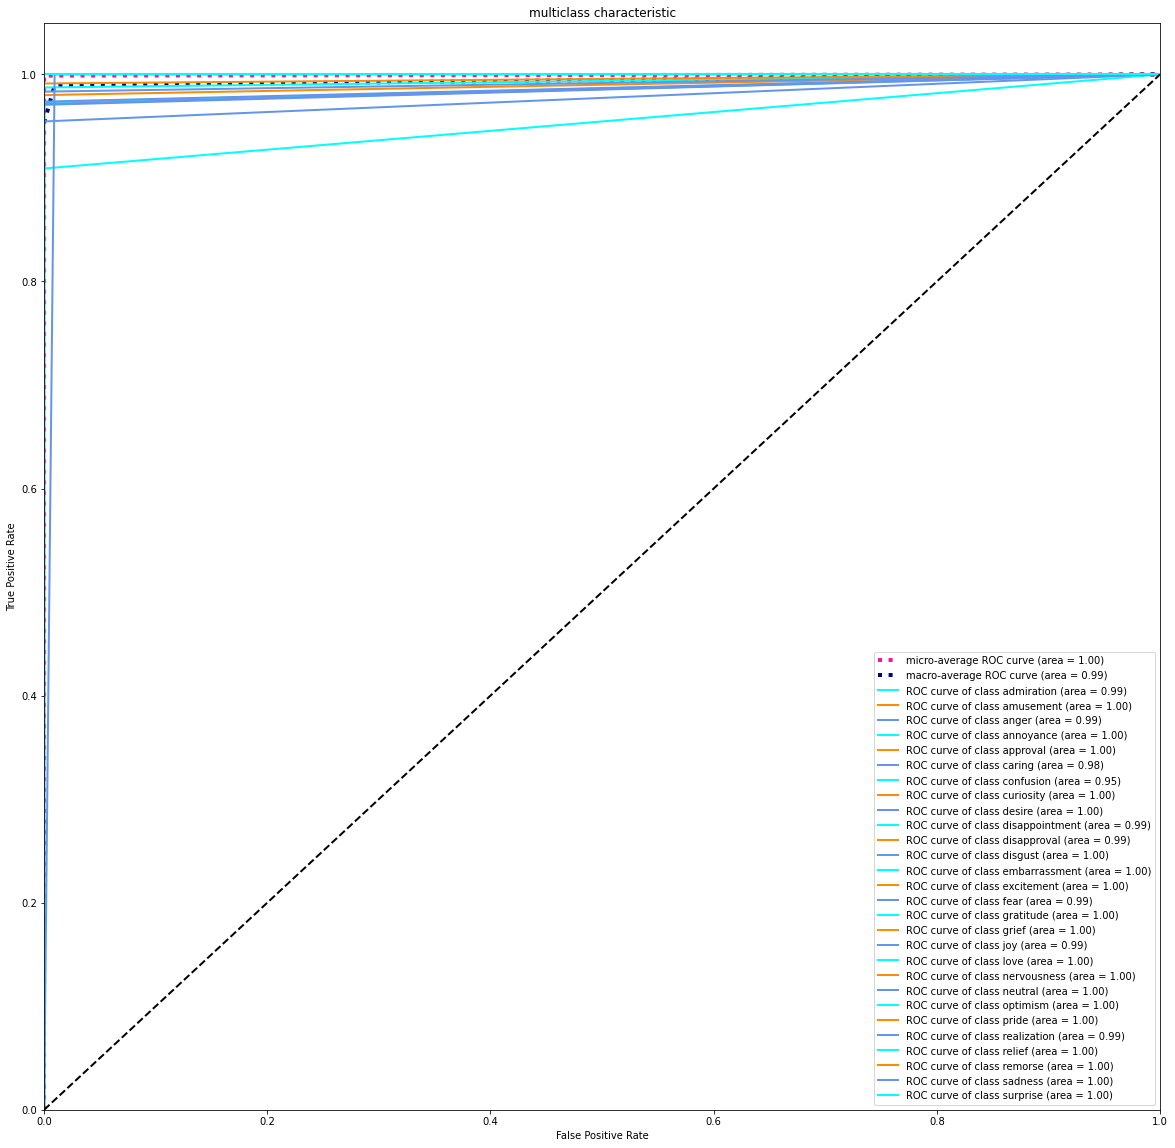

Accuracy:  0.9987952661044576
Precision::  0.9987952661044576
Recall::  0.9987952661044576
F1_Score::  0.9987952661044576

Macro precision_recall_fscore_support (macro) average
(0.9999507548984392, 0.9890779515157916, 0.994381802730257, None)

Macro precision_recall_fscore_support (micro) average
(0.9987952661044576, 0.9987952661044576, 0.9987952661044576, None)

Macro precision_recall_fscore_support (weighted) average
(0.9987969272672627, 0.9987952661044576, 0.9987878511508851, None)

Confusion Matrix

Classification Report
                precision    recall  f1-score   support

    admiration       1.00      0.99      0.99        79
     amusement       1.00      1.00      1.00         4
         anger       1.00      0.97      0.99        34
     annoyance       1.00      1.00      1.00        18
      approval       1.00      0.99      1.00       568
        caring       1.00      0.95      0.98        44
     confusion       1.00      0.91      0.95        11
     curiosity      

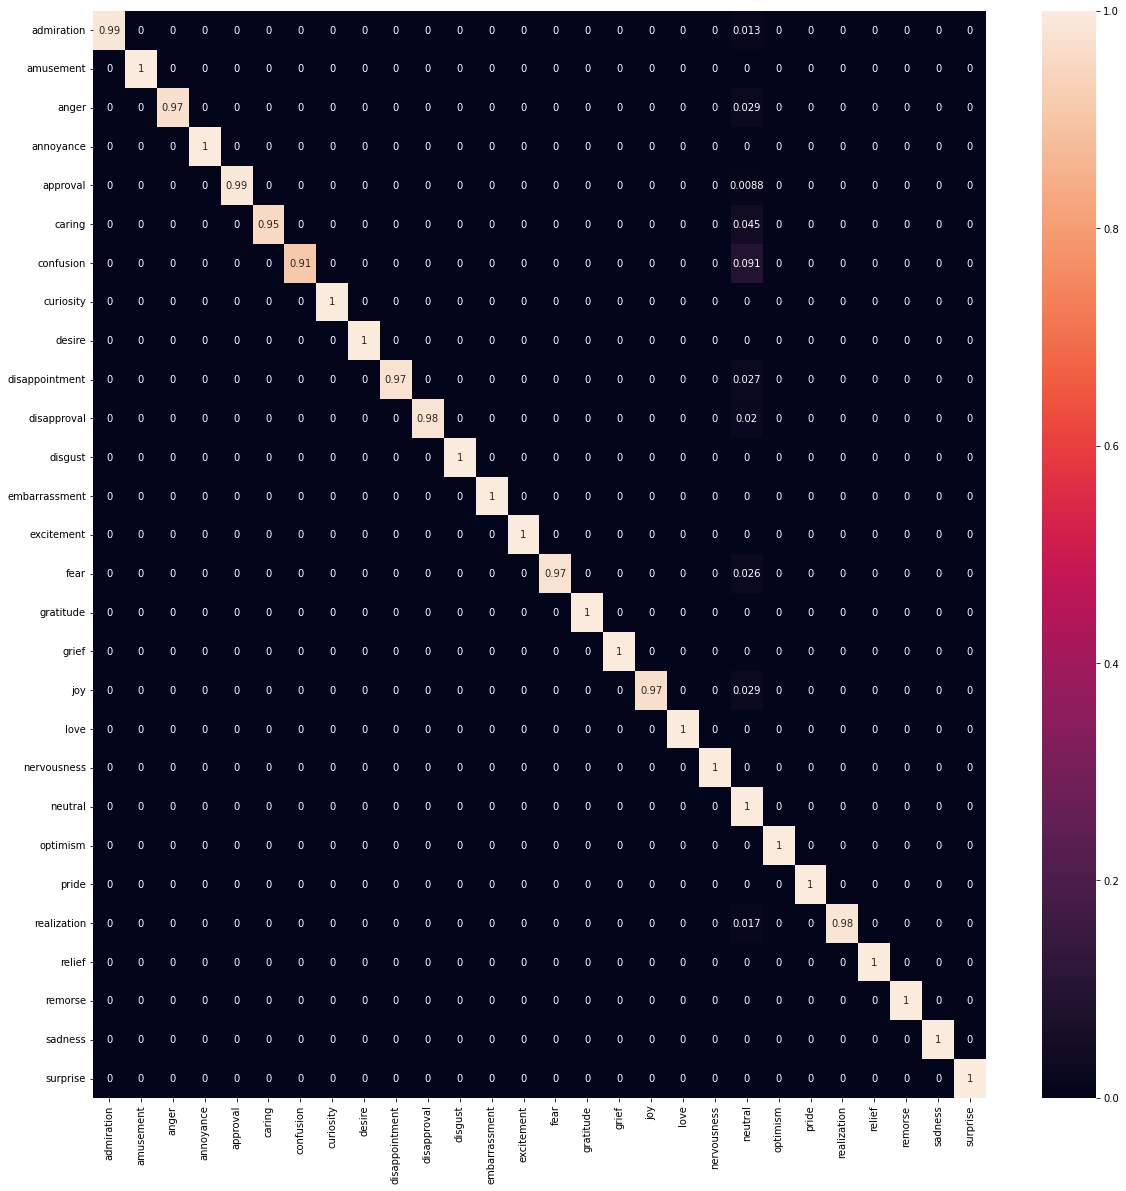

In [38]:
y_hat = grid.best_estimator_.predict(X_train_tfidf)
y_train_ohe = one_hot_encode(y_train, num_classes)
y_hat_ohe = one_hot_encode(y_hat, num_classes)
ROC_plot(y_train_ohe, y_hat_ohe, label_encoder, num_classes)
print_score(y_hat, y_train, label_encoder)

**Model2:**

In [41]:
SEQ_LEN = max([len(x.split()) for x in train["News_Title"].values])
SEQ_LEN

27

In [42]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
import nltk

nltk.download('punkt')
nltk.download('wordnet')

oov_tok = "<oov_tok>"

def count_vectorizer(corpus):
    vectorizer = CountVectorizer(analyzer='word')
    corpus_words = vectorizer.fit_transform(corpus)
    return len(vectorizer.vocabulary_)


def get_tokenizer_obj(text_list, num_words):
    tokenizer = Tokenizer(lower=True, split=" ", num_words=num_words, oov_token=oov_tok)
    tokenizer.fit_on_texts(text_list)
    return tokenizer, len(tokenizer.word_index)


def tokenize_texts_to_sequences(tokenizer, text_list):
     return tokenizer.texts_to_sequences(text_list)

    
def padding_sequences(x_arr, max_len):
    x_arr = pad_sequences(x_arr, maxlen=max_len, value=0, padding='post')
    return x_arr 


def get_num_words(df, col):
    return count_vectorizer(df[col])


def get_max_statment_len(df, col):
    return max([len(text.split()) for text in df[col]])

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [43]:
col = "News_Title"
num_words = get_num_words(train, col)
max_statment_len = get_max_statment_len(train, col)
tokenizer, vocab_size = get_tokenizer_obj(train[col].values, num_words)
X_train = tokenize_texts_to_sequences(tokenizer, train[col].values)
X_train = padding_sequences(X_train, max_statment_len)

In [44]:
X_val = tokenize_texts_to_sequences(tokenizer, val[col].values)
X_val = padding_sequences(X_val, max_statment_len)

In [45]:
from sklearn.utils import class_weight

def get_class_weights(y):
    class_weights = class_weight.compute_class_weight('balanced',
                                                      classes=np.unique(y),
                                                      y=y)
    return {k: v for k, v in enumerate(class_weights)}

In [46]:
train[['News_Title', 'Emotion']]

News_Title  Emotion
4433   NEPRA to mull over hike in power tariff for ho...       20
3302   COAS stresses need for efforts to avert loomin...       20
11391  5.3-magnitude of Earthquake hits  Gilgit-Balti...       20
8855   Imran Niazi imposed civilian martial law by di...       20
12796  In pictures: Aamir Liaquat Hussain ties knot f...       20
...                                                  ...      ...
9723   92% Pakistanis think inflation highest in PTIÃ...       20
4779   Naukot women gang-rape: Two key suspects still...       20
12456  Security Forces kill terrorist in North Waziri...       20
10809  Court directs customs to return Czech model Te...       20
2760   Beijing hoped to avoid such drama by acting sw...       21

[14111 rows x 2 columns]

In [48]:
y_train = one_hot_encode(train["Emotion"], num_classes)
y_val = one_hot_encode(val["Emotion"], num_classes)

In [49]:


y_train.shape



(14111, 28)

In [50]:
!pip install livelossplot

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [51]:
import tensorflow as tf
import keras.backend as K


def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

In [52]:
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Input, Dropout, Conv1D, Reshape, Permute, Lambda
from keras.layers import RepeatVector, Flatten, multiply, Dropout
from keras.models import Model
from keras.metrics import Recall, Precision
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from livelossplot import PlotLossesKeras
from os.path import join
import time


def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(128)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return modell

SINGLE_ATTENTION_VECTOR = False
def attention_3d_block(inputs, TIME_STEPS):
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, TIME_STEPS))(a) 
    a = Dense(TIME_STEPS, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = multiply([inputs, a_probs])
    return output_attention_mul

def build_model(MAX_NB_WORDS,
                MAX_TEXT_LEN,
                nb_classes,
                learning_rate=2e-5,
                epsilon=1e-08):
    EMBEDDING_DIM = 100
    inputs = Input(name='inputs',shape=[MAX_TEXT_LEN])
    layer = Embedding(MAX_NB_WORDS,EMBEDDING_DIM,input_length=MAX_TEXT_LEN)(inputs)
    lstm_units = 64
    lstm_out = LSTM(lstm_units, return_sequences=True)(layer)
    attention_mul = attention_3d_block(lstm_out, MAX_TEXT_LEN)
    attention_mul = Flatten()(attention_mul)
    output = Dense(nb_classes, activation='softmax')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate,epsilon=epsilon),
                  loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall(), f1_score])
    print(model.summary())
    return model


def train_model(model, X_train, y_train, X_val, y_val,
                #class_weights,
                weights_dir,
                epochs=20,
                mini_batch_size=32,
                ):
    model_weights_file_path = join(weights_dir, "custom_model_weights.h5")
    checkpoint = ModelCheckpoint(filepath=model_weights_file_path, monitor="val_accuracy", verbose=1, save_best_only=True, mode="max", save_weights_only=True)
    early_stopping = EarlyStopping(monitor="val_accuracy", mode="max", verbose=1, patience=5)
    plotlosses = PlotLossesKeras()
    call_backs = [checkpoint, early_stopping, plotlosses]
    start_time = time.time()

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=epochs,
                        batch_size=mini_batch_size,
                        callbacks=call_backs,
                        #class_weight=class_weights,
                        verbose=1)

    duration = time.time() - start_time
    print("Model take {} S to train ".format(duration))
    return model, history


def predict(model, X_test):
    return model.predict(X_test)

In [53]:
max_text_length = X_train.shape[1]
model = build_model(vocab_size,                    
                    max_text_length,
                    num_classes,
                    learning_rate=0.001)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 27)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 27, 100)      1434400     inputs[0][0]                     
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 27, 64)       42240       embedding[0][0]                  
__________________________________________________________________________________________________
permute (Permute)               (None, 64, 27)       0           lstm[0][0]                       
______________________________________________________________________________________________

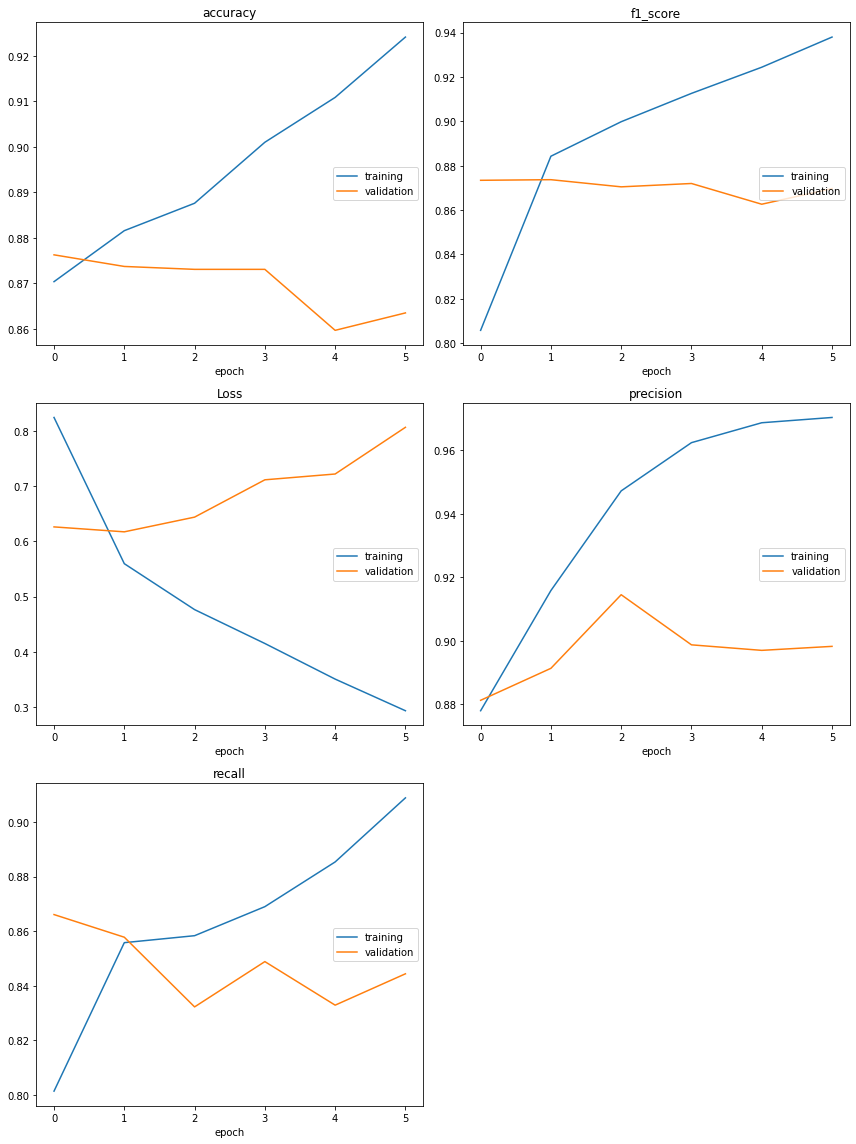

accuracy
	training         	 (min:    0.870, max:    0.924, cur:    0.924)
	validation       	 (min:    0.860, max:    0.876, cur:    0.864)
f1_score
	training         	 (min:    0.806, max:    0.938, cur:    0.938)
	validation       	 (min:    0.863, max:    0.874, cur:    0.870)
Loss
	training         	 (min:    0.293, max:    0.825, cur:    0.293)
	validation       	 (min:    0.617, max:    0.807, cur:    0.807)
precision
	training         	 (min:    0.878, max:    0.970, cur:    0.970)
	validation       	 (min:    0.881, max:    0.915, cur:    0.898)
recall
	training         	 (min:    0.801, max:    0.909, cur:    0.909)
	validation       	 (min:    0.832, max:    0.866, cur:    0.844)
Epoch 00006: early stopping
Model take 28.9087655544281 S to train 


(<keras.engine.functional.Functional at 0x7f52cf657490>,
 <keras.callbacks.History at 0x7f52cf443d50>)

In [54]:


weights_path = ""
train_model(model, X_train, y_train, 
            X_val, y_val,
            #class_weights,
            weights_path)



# **Event Wise Data Analysis**

In [62]:
news_df.to_csv('emotion.csv')

In [63]:
art_df = pd.read_csv('../input/plotting/emotion1.csv', encoding='latin1')

<AxesSubplot:xlabel='Author', ylabel='count'>

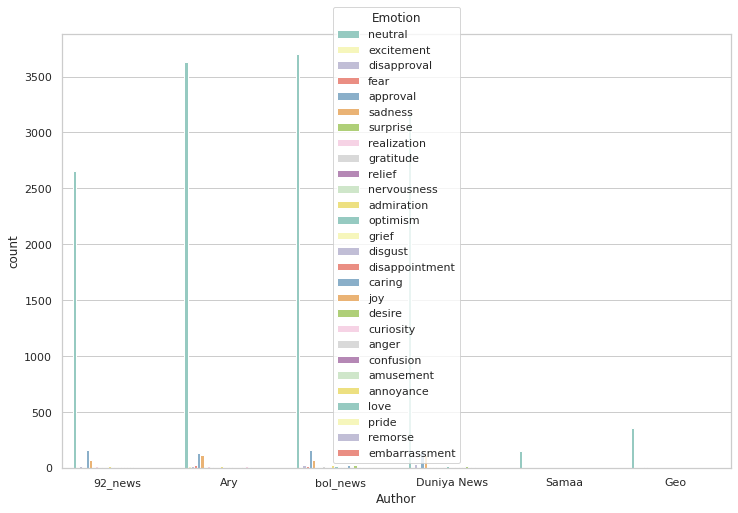

In [65]:
plt.figure(figsize=(12,8))
sns.set_theme(style='whitegrid')
sns.countplot(x=art_df.Author, hue=art_df.Emotion, palette='Set3')


In [191]:
df_solution = art_df.pivot_table(index=['Author','Emotion'], aggfunc='size')

In [197]:
df_solution

Author    Emotion    
92_news   admiration      24
          amusement        1
          anger            6
          approval       167
          caring           7
                        ... 
bol_news  realization      8
          relief           2
          remorse          2
          sadness         72
          surprise         4
Length: 130, dtype: int64

In [198]:
(art_df.groupby('Emotion')['Author']
   .value_counts(normalize=True).mul(100).round(2)
   .sort_index()
   .to_frame(name='Result_%')
).reset_index()

Emotion       Author  Result_%
0    admiration      92_news     27.27
1    admiration          Ary     25.00
2    admiration  Duniya News     15.91
3    admiration          Geo      1.14
4    admiration     bol_news     30.68
..          ...          ...       ...
125    surprise          Ary     53.33
126    surprise  Duniya News      3.33
127    surprise          Geo      3.33
128    surprise        Samaa      3.33
129    surprise     bol_news     13.33

[130 rows x 3 columns]

In [201]:
pd.crosstab(index=[art_df['Emotion']], 
            columns=art_df['Author'], 
            margins=True, margins_name='Total_Attempts')

Author          92_news   Ary  Duniya News  Geo  Samaa  bol_news  \
Emotion                                                            
admiration           24    22           14    1      0        27   
amusement             1     4            0    0      0         0   
anger                 6     8           11    0      0        13   
annoyance             0     3            5    2      0        10   
approval            167   134          151   10      7       162   
caring                7     7            9    0      0        26   
confusion             1     5            4    1      0         1   
curiosity             4    19            7    3      1        16   
desire               11     9           23    1      1        27   
disappointment       11     7           10    0      1        12   
disapproval          23    21           36    4      0        27   
disgust               3    10            5    1      0         9   
embarrassment         0     0            2    1      0         2   
excitement           15    25           10    2      1         9   
fear                 13    32           15    3      1        20   
gratitude             9     9            9    1      0        21   
grief                 9     5            6    2      1         6   
joy                  13     7            8    0      0        11   
love                  0     3            1    0      0         1   
nervousness           4     3            0    1      0         4   
neutral            2655  3632         3178  358    158      3699   
optimism             15     7           23    3      2        19   
pride                 0     1            1    0      0         1   
realization          22    25           11    1      0         8   
relief                2     0            0    0      0         2   
remorse               0     0            3    0      0         2   
sadness              77   117          118    5      2        72   
surprise              7    16            1    1      1         4   
Total_Attempts     3099  4131         3661  401    176      4211   

Author          Total_Attempts  
Emotion                         
admiration                  88  
amusement                    5  
anger                       38  
annoyance                   20  
approval                   631  
caring                      49  
confusion                   12  
curiosity                   50  
desire                      72  
disappointment              41  
disapproval                111  
disgust                     28  
embarrassment                5  
excitement                  62  
fear                        84  
gratitude                   49  
grief                       29  
joy                         39  
love                         5  
nervousness                 12  
neutral                  13680  
optimism                    69  
pride                        3  
realization                 67  
relief                       4  
remorse                      5  
sadness                    391  
surprise                    30  
Total_Attempts           15679